In [2]:
import pkgutil, sys
mods = [m.name for m in pkgutil.iter_modules()]
print("keras" in mods)  # should be False


False


In [3]:
# Install Keras 3 (works with TF 2.16/2.17+)
%pip install -U "keras>=3.4.1" keras-core tensorflow-io-gcs-filesystem

# After this finishes, please: Kernel → Restart Kernel


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------- ----------------- 0.8/1.4 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 8.2 MB/s  0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   ---------------------------------------- 950.8/950.8 kB 8.8 MB/s  0:00:00

   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ------------- -------------------------- 1/3 [keras-core]
   ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.
tensorflow-intel 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.15.2 which is incompatible.


In [4]:
# Must set backend BEFORE importing keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models   # <-- use these in your code
import tensorflow as tf

print("TF:", tf.__version__)
print("Keras:", keras.__version__)


TF: 2.18.0
Keras: 3.11.3


In [5]:
%pip install --quiet pandas numpy scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
# === Cell 1 — core imports & paths (fixed) ===
import json, math, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier

import tensorflow as tf  # <-- missing before; required for set_seed etc.

# Your PhysioNet folder
DATA_ROOT = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\physionet_dataset")
SET_A = DATA_ROOT/"training_setA"
SET_B = DATA_ROOT/"training_setB"
CSV_FALLBACK = DATA_ROOT/"Dataset.csv"  # if present

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Paths exist:", SET_A.exists(), SET_B.exists(), CSV_FALLBACK.exists())


Paths exist: True True True


In [7]:
# === Cell 2 (robust loader; replace previous Cell 2 entirely) ===
def read_psv_folder(folder: Path):
    files = sorted(folder.glob("*.psv"))
    out = []
    for fp in files:
        pid = fp.stem  # e.g., p000001
        try:
            df = pd.read_csv(fp, sep="|")
            df.insert(0, "PatientID", pid)
            out.append(df)
        except Exception as e:
            print(f"[WARN] Failed to read {fp.name}: {e}")
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

dfA = read_psv_folder(SET_A) if SET_A.exists() else pd.DataFrame()
dfB = read_psv_folder(SET_B) if SET_B.exists() else pd.DataFrame()

# Columns we care about (missing ones will be created as NaN)
COLUMNS_KEEP = [
    "ICULOS","SepsisLabel","HR","O2Sat","Temp","SBP","MAP","DBP","Resp","EtCO2",
    "BaseExcess","HCO3","FiO2","pH","PaCO2","SaO2","AST","BUN","Alkalinephos","Calcium",
    "Chloride","Creatinine","Bilirubin_direct","Glucose","Lactate","Magnesium","Phosphate",
    "Potassium","Bilirubin_total","TroponinI","Hct","Hgb","PTT","WBC","Fibrinogen","Platelets",
    "Age","Gender","Unit1","Unit2","HospAdmTime"
]

def load_dataset_csv_stream(csv_path: Path, max_patients: int | None = None, chunksize: int = 200_000):
    """
    Stream-read Dataset.csv, reconstruct PatientID using ICULOS resets/non-increasing steps,
    downcast to float32. Works across chunk boundaries.
    """
    # Probe columns
    probe = pd.read_csv(csv_path, nrows=5)
    head_cols = set(probe.columns)
    usecols = [c for c in COLUMNS_KEEP if c in head_cols]
    # time column
    time_col = "ICULOS" if "ICULOS" in head_cols else ("Hour" if "Hour" in head_cols else None)
    if time_col not in usecols and time_col is not None:
        usecols.append(time_col)
    if time_col is None:
        raise ValueError("Could not find 'ICULOS' or 'Hour' column in Dataset.csv")

    collected = []
    # running state across chunks:
    patient_index = -1
    last_time = None

    total_patients = 0

    for chunk in pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize):
        if "ICULOS" not in chunk.columns and "Hour" in chunk.columns:
            chunk = chunk.rename(columns={"Hour": "ICULOS"})

        # Downcast numeric columns to float32
        for c in chunk.columns:
            chunk[c] = pd.to_numeric(chunk[c], errors="coerce").astype("float32")

        # Detect new patient starts:
        # Within the chunk, a new patient starts when ICULOS is <= previous ICULOS (non-increasing)
        icu = chunk["ICULOS"].values
        starts = np.zeros(len(chunk), dtype=bool)
        # first row of chunk: compare to last_time of previous chunk
        if last_time is None or (icu[0] <= last_time):
            starts[0] = True
        # inside chunk
        if len(icu) > 1:
            diffs = np.diff(icu)
            starts[1:] |= (diffs <= 0)

        # Assign running patient indices
        patient_ids = np.empty(len(chunk), dtype=np.int64)
        for i, is_start in enumerate(starts):
            if is_start:
                patient_index += 1
            patient_ids[i] = patient_index

        chunk["PatientID"] = ["p" + str(i).zfill(6) for i in patient_ids]
        last_time = float(icu[-1]) if len(icu) else last_time

        # Count new patients in this chunk
        num_new = int(starts.sum())
        total_patients += num_new

        collected.append(chunk)

        # Stop early if requested
        if max_patients is not None and total_patients >= max_patients:
            break

    if not collected:
        return pd.DataFrame()

    df = pd.concat(collected, ignore_index=True)

    # If over-read, trim to max_patients
    if max_patients is not None:
        keep_ids = set("p" + str(i).zfill(6) for i in range(max_patients))
        df = df[df["PatientID"].isin(keep_ids)].copy()

    # Ensure all desired columns exist
    for c in COLUMNS_KEEP:
        if c not in df.columns:
            df[c] = np.nan

    # Final order
    cols = ["PatientID","ICULOS","SepsisLabel"] + [c for c in COLUMNS_KEEP if c not in ("ICULOS","SepsisLabel")]
    cols = [c for c in cols if c in df.columns]
    df = df[cols]

    return df

if not dfA.empty or not dfB.empty:
    ts_df = pd.concat([dfA, dfB], ignore_index=True)
    source = "PSV"
else:
    # Adjust max_patients if RAM is tight; try 1000 if needed
    ts_df = load_dataset_csv_stream(CSV_FALLBACK, max_patients=2000, chunksize=200_000)
    source = "CSV-stream"

print(f"Loaded from: {source} | shape: {ts_df.shape}")
print("Columns:", list(ts_df.columns)[:10], "...")
print("Example rows:")
ts_df.head(3)


Loaded from: CSV-stream | shape: (78417, 42)
Columns: ['PatientID', 'ICULOS', 'SepsisLabel', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp'] ...
Example rows:


,PatientID,ICULOS,SepsisLabel,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime
0,p000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.540001,0.0,NaN,NaN,-0.02
1,p000000,2.0,0.0,65.0,100.0,NaN,NaN,72.0,NaN,16.5,...,NaN,NaN,NaN,NaN,NaN,68.540001,0.0,NaN,NaN,-0.02
2,p000000,3.0,0.0,78.0,100.0,NaN,NaN,42.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.540001,0.0,NaN,NaN,-0.02


In [8]:
# === Sanity check (run after Cell 2) ===
if ts_df.empty:
    raise RuntimeError("Loaded dataframe is EMPTY. Check file paths or lower max_patients in the CSV loader.")
n_patients = ts_df["PatientID"].nunique()
print("Unique patients:", n_patients)
print(ts_df.groupby("PatientID").size().describe())


Unique patients: 2000
count    2000.000000
mean       39.208500
std        23.251567
min         8.000000
25%        25.000000
50%        39.000000
75%        47.250000
max       275.000000
dtype: float64


In [9]:
# Standardize column names
ts_df.columns = [c.strip().replace(" ", "_") for c in ts_df.columns]

# Ensure key columns exist
assert "PatientID" in ts_df.columns
assert "SepsisLabel" in ts_df.columns, "Expect a 0/1 'SepsisLabel' per time step"

# Decide time column
time_col = "ICULOS" if "ICULOS" in ts_df.columns else ("Hour" if "Hour" in ts_df.columns else None)
if time_col is None:
    ts_df["ICULOS"] = ts_df.groupby("PatientID").cumcount()
    time_col = "ICULOS"

# Sort
ts_df = ts_df.sort_values(["PatientID", time_col]).reset_index(drop=True)

# Replace common sentinels with NaN
ts_df = ts_df.replace([-1, "-1", "NaN", "nan", "None", ""], np.nan)

# Numeric feature list (exclude label)
num_cols = [c for c in ts_df.columns if ts_df[c].dtype != "O" and c not in ["SepsisLabel"]]
print("n numeric features:", len(num_cols))

# Prevalence (patient-level: any-time positive)
prev = ts_df.drop_duplicates("PatientID")["SepsisLabel"].mean()
print(f"Patient-level prevalence (any sepsis): {prev:.3f}")


n numeric features: 40
Patient-level prevalence (any sepsis): 0.009


In [10]:
# === Cell 4 (safe split) ===
patients = ts_df["PatientID"].unique().tolist()
n = len(patients)
print("Total patients:", n)

if n < 5:
    # not enough to split — either lower max_patients or confirm data
    raise RuntimeError(
        f"Only {n} patients loaded. "
        "Increase 'max_patients' in the CSV loader, or verify training_setA/B folders."
    )

tr_p, te_p = train_test_split(patients, test_size=0.2, random_state=RANDOM_STATE)
tr_p, va_p = train_test_split(tr_p, test_size=0.2, random_state=RANDOM_STATE)

split_map = {**{p:"train" for p in tr_p}, **{p:"val" for p in va_p}, **{p:"test" for p in te_p}}
ts_df["split"] = ts_df["PatientID"].map(split_map)

print("train/val/test patients:", len(tr_p), len(va_p), len(te_p))


Total patients: 2000
train/val/test patients: 1280 320 400


In [20]:
# === Cell 5 — imputation (ffill→train median), scaling, and sanitization (FIXED) ===
def ffill_by_patient(df, cols):
    return df.groupby("PatientID", group_keys=False)[cols].apply(lambda g: g.ffill())

work = ts_df.copy()

# Ensure label exists and is clean
assert "SepsisLabel" in work.columns, "Expected SepsisLabel column (0/1 per timestep)."
work["SepsisLabel"] = pd.to_numeric(work["SepsisLabel"], errors="coerce").fillna(0.0).clip(0, 1).astype(np.float32)

# Numeric columns (exclude label)
num_cols = [c for c in work.columns if work[c].dtype != "O" and c not in ["SepsisLabel"]]

# Forward fill within patient, then fill remaining with TRAIN medians
work[num_cols] = ffill_by_patient(work, num_cols)
train_meds = work.loc[work["split"]=="train", num_cols].median(numeric_only=True)
work[num_cols] = work[num_cols].fillna(train_meds)

# Standardize numeric using TRAIN split only
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_mask = work["split"]=="train"
work.loc[train_mask, num_cols] = scaler.fit_transform(work.loc[train_mask, num_cols])
work.loc[~train_mask, num_cols] = scaler.transform(work.loc[~train_mask, num_cols])

# Replace any remaining inf/nan just in case
work[num_cols] = (work[num_cols]
                  .replace([np.inf, -np.inf], np.nan)
                  .fillna(0.0)
                  .astype(np.float32))

print("Any NaNs left in X?", work[num_cols].isna().any().any())
print("Label distribution:", work["SepsisLabel"].value_counts(dropna=False).to_dict())


Any NaNs left in X? False
Label distribution: {0.0: 76705, 1.0: 1712}


C:\Users\sarve\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\sarve\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\sarve\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [21]:
# === Cell 6 — variable-length sequences, padded with a unique value, plus sample_weight (FIXED) ===
import tensorflow as tf
FEATURES = num_cols
LABEL    = "SepsisLabel"

PAD_X = np.float32(-999.0)  # unique pad value not present after standardization
PAD_Y = np.float32(0.0)     # labels padded with 0; we will mask them via sample_weight=0

def to_sequences(df, split):
    Xs, ys = [], []
    for pid, g in df[df["split"]==split].groupby("PatientID"):
        X = g[FEATURES].to_numpy(np.float32)        # [T, F]
        y = g[LABEL].to_numpy(np.float32)           # [T]
        Xs.append(X)
        ys.append(y)
    return Xs, ys

X_tr, y_tr = to_sequences(work, "train")
X_va, y_va = to_sequences(work, "val")
X_te, y_te = to_sequences(work, "test")

def to_padded_ds(X_list, y_list, batch=32, shuffle=False):
    def gen():
        for x, y in zip(X_list, y_list):
            # shapes: x=[T,F], y=[T] → expand y to [T,1]
            y_exp = np.expand_dims(y, -1).astype(np.float32)
            # per-timestep weights 1.0 (real timesteps); padding will be handled after padded_batch
            sw = np.ones_like(y_exp, dtype=np.float32)  # [T,1]
            yield x.astype(np.float32), y_exp, sw

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, len(FEATURES)), dtype=tf.float32),  # X
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),              # y
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),              # sample_weight
        )
    )
    if shuffle:
        ds = ds.shuffle(len(X_list), seed=42)

    # Pad to the longest sequence in the batch
    ds = ds.padded_batch(
        batch_size=batch,
        padded_shapes=([None, len(FEATURES)], [None, 1], [None, 1]),
        padding_values=(PAD_X, PAD_Y, 0.0),  # sample_weight padding = 0 so padded steps don't affect loss
        drop_remainder=False
    )

    # (Optional) prefetch for speed
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

BATCH = 32
ds_tr = to_padded_ds(X_tr, y_tr, batch=BATCH, shuffle=True)
ds_va = to_padded_ds(X_va, y_va, batch=BATCH, shuffle=False)
ds_te = to_padded_ds(X_te, y_te, batch=BATCH, shuffle=False)

len(X_tr), len(X_va), len(X_te)


(1280, 320, 400)

In [22]:
# === Cell 7 — LSTM model with proper masking (FIXED) ===
import keras
from keras import layers, models

keras.backend.clear_session()

F = len(FEATURES)
inp = layers.Input(shape=(None, F))
x = layers.Masking(mask_value=PAD_X)(inp)        # match the PAD_X used in the dataset
x = layers.LSTM(96, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(64, return_sequences=True)(x)
out = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"))(x)

model = models.Model(inp, out)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc", curve="ROC")]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 40)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 40)  │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 40)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 96)  │     52,608 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 96)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, None, 64)  │     41,216 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │         65 │ lstm_1[0][0],     │
│ (TimeDistributed)   │                   │            │ any[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,889 (366.75 KB)

 Trainable params: 93,889 (366.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
     40/Unknown 7s 86ms/step - auc: 0.5988 - loss: 0.4321

C:\Users\sarve\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - auc: 0.5892 - loss: 0.2870 - val_auc: 0.6897 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.7063 - loss: 0.1388 - val_auc: 0.7404 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - auc: 0.7841 - loss: 0.1219 - val_auc: 0.7424 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - auc: 0.8128 - loss: 0.1091 - val_auc: 0.7594 - val_loss: 0.1252 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.8369 - loss: 0.0999 - val_auc: 0.7578 - val_loss: 0.1237 - learning_rate: 0.0010
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - auc: 0.8596 - loss: 0.0930
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.8509 - loss: 0.0926 - val_auc: 0.7350 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 7/20
40/40 ━━

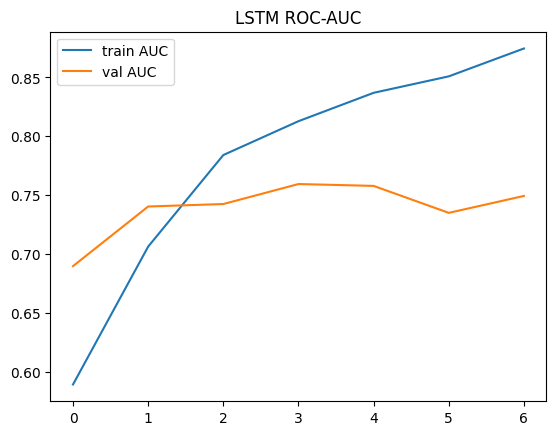

In [23]:
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
]

hist = model.fit(
    ds_tr, validation_data=ds_va,
    epochs=20, callbacks=cbs, verbose=1
)

plt.plot(hist.history["auc"], label="train AUC")
plt.plot(hist.history["val_auc"], label="val AUC")
plt.legend(); plt.title("LSTM ROC-AUC"); plt.show()


In [24]:
# === Cell 9 — evaluation (step-wise) ===
y_true_steps, y_prob_steps = [], []
for xb, yb, sw in ds_te:                 # now dataset yields 3 items
    pb = model.predict(xb, verbose=0)    # [B, T, 1]
    y_true_steps.append(yb.numpy().squeeze(-1))   # [B, T]
    y_prob_steps.append(pb.squeeze(-1))           # [B, T]

y_true_steps = np.concatenate([a.ravel() for a in y_true_steps])
y_prob_steps = np.concatenate([a.ravel() for a in y_prob_steps])

mask = ~np.isnan(y_true_steps) & ~np.isnan(y_prob_steps)
y_true_steps = y_true_steps[mask].astype(int)
y_prob_steps = y_prob_steps[mask].astype(float)

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

auroc = roc_auc_score(y_true_steps, y_prob_steps) if len(np.unique(y_true_steps))==2 else float("nan")
auprc = average_precision_score(y_true_steps, y_prob_steps) if len(np.unique(y_true_steps))==2 else float("nan")

fpr, tpr, thr = roc_curve(y_true_steps, y_prob_steps)
best_thr = float(thr[np.argmax(tpr - fpr)]) if len(thr) else 0.5

y_pred_steps = (y_prob_steps >= best_thr).astype(int)
acc  = accuracy_score(y_true_steps, y_pred_steps)
prec = precision_score(y_true_steps, y_pred_steps, zero_division=0)
rec  = recall_score(y_true_steps, y_pred_steps, zero_division=0)
f1   = f1_score(y_true_steps, y_pred_steps, zero_division=0)
cm   = confusion_matrix(y_true_steps, y_pred_steps, labels=[0,1])

print(f"Step-wise — AUROC: {auroc:.4f} | AUPRC: {auprc:.4f} | Thr*: {best_thr:.3f}")
print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
print("Confusion [rows=true, cols=pred]:\n", cm)


Step-wise — AUROC: 0.7153 | AUPRC: 0.0323 | Thr*: 0.030
Acc: 0.8193 | Prec: 0.0193 | Rec: 0.5170 | F1: 0.0372
Confusion [rows=true, cols=pred]:
 [[32032  6967]
 [  128   137]]
